# Amazon Reviews Baseline Recommendation System

This notebook implements a baseline ItemKNN recommendation system for the Amazon Handmade Products dataset.

**Dataset Structure:**
- User Reviews: `Handmade_Products.jsonl.gz`
- Item Metadata: `meta_Handmade_Products.jsonl.gz`

**Reference:** [Amazon Reviews 2023 Dataset](https://amazon-reviews-2023.github.io/main.html)


In [1]:
# Import required libraries
import json
import gzip
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Data Preprocessing


In [2]:
def load_jsonl(filepath):
    data = []
    try:
        # Changed gzip.open to standard open()
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in tqdm(f, desc=f"Loading {os.path.basename(filepath)}"):
                if line.strip():
                    data.append(json.loads(line))
    except Exception as e:
        raise Exception(f"Error loading {filepath}: {str(e)}")
    
    return data

# Load datasets
print("Loading review data...")
reviews = load_jsonl('/kaggle/input/amazon-product-review-handmade-products/Handmade_Products.jsonl/Handmade_Products.jsonl')

print("Loading metadata...")
metadata = load_jsonl('/kaggle/input/amazon-product-review-handmade-products/meta_Handmade_Products.jsonl/meta_Handmade_Products.jsonl')

print(f"\nLoaded {len(reviews)} reviews and {len(metadata)} items")


Loading review data...


Loading Handmade_Products.jsonl: 664162it [00:07, 85791.73it/s] 


Loading metadata...


Loading meta_Handmade_Products.jsonl: 164817it [00:08, 20398.56it/s]


Loaded 664162 reviews and 164817 items


In [3]:
def preprocess_reviews(reviews):
    """Extract relevant information from reviews."""
    processed = []
    for review in reviews:
        processed.append({
            'user_id': review.get('user_id', ''),
            'asin': review.get('asin', ''),
            'parent_asin': review.get('parent_asin', ''),
            'rating': review.get('rating', 0.0),
            'title': review.get('title', ''),
            'text': review.get('text', ''),
            'helpful_vote': review.get('helpful_vote', 0),
            'verified_purchase': review.get('verified_purchase', False),
            'timestamp': review.get('timestamp', 0)
        })
    return pd.DataFrame(processed)

# Convert to DataFrame
df_reviews = preprocess_reviews(reviews)
print(f"Reviews DataFrame shape: {df_reviews.shape}")
print(f"\nSample data:")
print(df_reviews.head())
print(f"\nUnique users: {df_reviews['user_id'].nunique()}")
print(f"Unique items: {df_reviews['parent_asin'].nunique()}")
print(f"Average rating: {df_reviews['rating'].mean():.2f}")


Reviews DataFrame shape: (664162, 9)

Sample data:
                        user_id        asin parent_asin  rating  \
0  AF7OANMNHQJC3PD4HRPX2FATECPA  B08GPJ1MSN  B08GPJ1MSN     5.0   
1  AGMJ3EMDVL6OWBJF7CA5RGJLXN5A  B084TWHS7W  B084TWHS7W     5.0   
2  AEYORY2AVPMCPDV57CE337YU5LXA  B07V3NRQC4  B07V3NRQC4     5.0   
3  AEINY4XOINMMJCK5GZ3M6MMHBN6A  B071ZMDK26  B071ZMDK26     5.0   
4  AGCPAPUHXYA3EEIL2KGSQTGO5HRA  B01MPVZ4YP  B01MPVZ4YP     5.0   

                                        title  \
0                            Beautiful colors   
1  You simply must order order more than one!   
2                                       Great   
3                  Well made and so beautiful   
4            Smells just like the real thing!   

                                                text  helpful_vote  \
0  I bought one for myself and one for my grandda...             1   
1  I’ve ordered three bows so far. Have not been ...             0   
2  As pictured. Used a frame from the dol

In [4]:
# Filter users and items with minimum interactions
MIN_USER_INTERACTIONS = 3
MIN_ITEM_INTERACTIONS = 3

print("Filtering users and items...")
user_counts = df_reviews['user_id'].value_counts()
item_counts = df_reviews['parent_asin'].value_counts()

valid_users = user_counts[user_counts >= MIN_USER_INTERACTIONS].index
valid_items = item_counts[item_counts >= MIN_ITEM_INTERACTIONS].index

df_filtered = df_reviews[
    (df_reviews['user_id'].isin(valid_users)) & 
    (df_reviews['parent_asin'].isin(valid_items))
].copy()

print(f"After filtering:")
print(f"  Users: {df_filtered['user_id'].nunique():,}")
print(f"  Items: {df_filtered['parent_asin'].nunique():,}")
print(f"  Interactions: {len(df_filtered):,}")


Filtering users and items...
After filtering:
  Users: 11,180
  Items: 15,810
  Interactions: 32,510


In [5]:
df_filtered.to_csv('data_filtered.csv')

In [6]:
# Create user and item mappings
unique_users = sorted(df_filtered['user_id'].unique())
unique_items = sorted(df_filtered['parent_asin'].unique())

user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}

item_to_idx = {item: idx for idx, item in enumerate(unique_items)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}

print(f"User mapping: {len(user_to_idx):,} users")
print(f"Item mapping: {len(item_to_idx):,} items")


User mapping: 11,180 users
Item mapping: 15,810 items


In [7]:
# Split data into train and test sets (80-20 split)
# Use temporal split based on timestamp
df_sorted = df_filtered.sort_values('timestamp')
split_idx = int(len(df_sorted) * 0.8)

df_train = df_sorted.iloc[:split_idx].copy()
df_test = df_sorted.iloc[split_idx:].copy()

print(f"Train set: {len(df_train):,} interactions")
print(f"Test set: {len(df_test):,} interactions")
print(f"\nTrain users: {df_train['user_id'].nunique():,}")
print(f"Test users: {df_test['user_id'].nunique():,}")


Train set: 26,008 interactions
Test set: 6,502 interactions

Train users: 9,730
Test users: 2,531


## 1.5. Compute Text Embeddings for Items


In [8]:
# Install sentence-transformers if not already installed
from sentence_transformers import SentenceTransformer

# Initialize the embedding model
print("Loading text embedding model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast and efficient model
print("Embedding model loaded successfully!")


2025-12-28 11:44:53.549523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766922293.704304      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766922293.751036      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766922294.106461      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766922294.106501      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766922294.106504      23 computation_placer.cc:177] computation placer alr

Loading text embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model loaded successfully!


In [9]:
def create_item_text(item_meta):
    """
    Combine title, description, and features into a single text string.
    
    Args:
        item_meta: Dictionary containing item metadata
        
    Returns:
        Combined text string
    """
    # Extract title
    title = item_meta.get('title', '')
    if isinstance(title, list):
        title = ' '.join(title)
    
    # Extract description
    description = item_meta.get('description', [])
    if isinstance(description, list):
        description = ' '.join([str(d) for d in description if d])
    else:
        description = str(description) if description else ''
    
    # Extract features
    features = item_meta.get('features', [])
    if isinstance(features, list):
        features = ' '.join([str(f) for f in features if f])
    else:
        features = str(features) if features else ''
    
    # Combine all text
    combined_text = f"{title} {description} {features}".strip()
    
    # If empty, return a placeholder
    if not combined_text:
        combined_text = "No description available"
    
    return combined_text

# Create a dictionary mapping parent_asin to metadata
print("Creating item metadata dictionary...")
item_metadata_dict = {}
for item in tqdm(metadata, desc="Processing metadata"):
    parent_asin = item.get('parent_asin', '')
    if parent_asin:
        item_metadata_dict[parent_asin] = item

print(f"Loaded metadata for {len(item_metadata_dict):,} items")


Creating item metadata dictionary...


Processing metadata: 100%|██████████| 164817/164817 [00:00<00:00, 1027015.88it/s]

Loaded metadata for 164,817 items


In [10]:
# Compute text embeddings for all items in our filtered dataset
print("Computing text embeddings for items...")
item_texts = []
item_indices = []

for item_asin in tqdm(unique_items, desc="Preparing item texts"):
    if item_asin in item_metadata_dict:
        text = create_item_text(item_metadata_dict[item_asin])
        item_texts.append(text)
        item_indices.append(item_to_idx[item_asin])
    else:
        # If metadata not found, use placeholder
        item_texts.append("No description available")
        item_indices.append(item_to_idx[item_asin])

print(f"Prepared texts for {len(item_texts):,} items")


Computing text embeddings for items...


Preparing item texts: 100%|██████████| 15810/15810 [00:00<00:00, 184870.00it/s]

Prepared texts for 15,810 items


In [11]:
# Compute embeddings in batches for efficiency
BATCH_SIZE = 64
item_embeddings = []

print("Computing embeddings...")
for i in tqdm(range(0, len(item_texts), BATCH_SIZE), desc="Embedding batches"):
    batch_texts = item_texts[i:i+BATCH_SIZE]
    batch_embeddings = embedding_model.encode(batch_texts, show_progress_bar=False)
    item_embeddings.append(batch_embeddings)

# Concatenate all embeddings
item_embeddings = np.vstack(item_embeddings)

print(f"Item embeddings shape: {item_embeddings.shape}")
print(f"Embedding dimension: {item_embeddings.shape[1]}")


Computing embeddings...


Embedding batches: 100%|██████████| 248/248 [00:26<00:00,  9.39it/s]

Item embeddings shape: (15810, 384)
Embedding dimension: 384


In [12]:
# Create a mapping from item index to embedding
# Note: item_embeddings[i] corresponds to unique_items[i]
item_embedding_matrix = np.zeros((len(item_to_idx), item_embeddings.shape[1]))

for i, item_asin in enumerate(unique_items):
    item_idx = item_to_idx[item_asin]
    item_embedding_matrix[item_idx] = item_embeddings[i]

print(f"Item embedding matrix shape: {item_embedding_matrix.shape}")
print("Text embeddings computed successfully!")


Item embedding matrix shape: (15810, 384)
Text embeddings computed successfully!


In [13]:
# Create interaction matrices
def create_interaction_matrix(df, user_to_idx, item_to_idx):
    """Create user-item interaction matrix."""
    n_users = len(user_to_idx)
    n_items = len(item_to_idx)
    matrix = np.zeros((n_users, n_items))
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Building matrix"):
        user_idx = user_to_idx[row['user_id']]
        item_idx = item_to_idx[row['parent_asin']]
        matrix[user_idx, item_idx] = row['rating']
    
    return matrix

train_matrix = create_interaction_matrix(df_train, user_to_idx, item_to_idx)
test_matrix = create_interaction_matrix(df_test, user_to_idx, item_to_idx)

print(f"Train matrix shape: {train_matrix.shape}")
print(f"Train matrix density: {(train_matrix > 0).sum() / train_matrix.size * 100:.4f}%")


Building matrix: 100%|██████████| 6502/6502 [00:00<00:00, 22758.26it/s]


Train matrix shape: (11180, 15810)
Train matrix density: 0.0133%


## 2. Model: ItemKNN (Item-based Collaborative Filtering)


In [14]:
class ItemKNN:
    """
    Item-based Collaborative Filtering using K-Nearest Neighbors.
    
    This baseline method recommends items based on similarity to items
    the user has already interacted with.
    """
    
    def __init__(self, k=50, similarity='cosine'):
        """
        Args:
            k: Number of nearest neighbors to consider
            similarity: Similarity metric ('cosine' or 'pearson')
        """
        self.k = k
        self.similarity = similarity
        self.item_similarity = None
        self.train_matrix = None
        
    def fit(self, train_matrix):
        """Train the model by computing item-item similarity matrix."""
        print(f"Computing item-item similarity matrix (k={self.k})...")
        self.train_matrix = train_matrix
        
        # Compute item-item similarity
        # Transpose to get items as rows
        item_matrix = train_matrix.T
        
        if self.similarity == 'cosine':
            # Compute cosine similarity
            self.item_similarity = cosine_similarity(item_matrix)
        else:
            # Pearson correlation
            item_matrix_normalized = item_matrix - item_matrix.mean(axis=1, keepdims=True)
            norm = np.linalg.norm(item_matrix_normalized, axis=1, keepdims=True)
            norm[norm == 0] = 1  # Avoid division by zero
            self.item_similarity = np.dot(item_matrix_normalized, item_matrix_normalized.T) / (norm * norm.T)
        
        # Set diagonal to 0 (items are not similar to themselves)
        np.fill_diagonal(self.item_similarity, 0)
        
        # Keep only top-k similarities for each item
        for i in range(len(self.item_similarity)):
            # Get indices of top-k similar items
            top_k_indices = np.argsort(self.item_similarity[i])[-self.k:][::-1]
            # Create mask to zero out non-top-k items
            mask = np.ones(len(self.item_similarity[i]), dtype=bool)
            mask[top_k_indices] = False
            self.item_similarity[i][mask] = 0
        
        print("Model training completed!")
        return self
    
    def predict(self, user_idx):
        """
        Predict ratings for a user.
        
        Args:
            user_idx: Index of the user
            
        Returns:
            Array of predicted ratings for all items
        """
        # Get user's interactions
        user_interactions = self.train_matrix[user_idx]
        
        # Compute predicted ratings
        # For each item, sum similarities weighted by user's ratings
        predictions = np.dot(self.item_similarity, user_interactions)
        
        # Normalize by sum of similarities
        similarity_sums = np.abs(self.item_similarity).sum(axis=0)
        similarity_sums[similarity_sums == 0] = 1  # Avoid division by zero
        predictions = predictions / similarity_sums
        
        return predictions
    
    def recommend(self, user_idx, n_recommendations=10, exclude_interacted=True):
        """
        Recommend top-n items for a user.
        
        Args:
            user_idx: Index of the user
            n_recommendations: Number of items to recommend
            exclude_interacted: Whether to exclude items user has already interacted with
            
        Returns:
            List of item indices (sorted by predicted rating)
        """
        predictions = self.predict(user_idx)
        
        if exclude_interacted:
            # Set interacted items to -inf
            interacted_items = self.train_matrix[user_idx] > 0
            predictions[interacted_items] = -np.inf
        
        # Get top-n items
        top_items = np.argsort(predictions)[-n_recommendations:][::-1]
        return top_items.tolist()

print("ItemKNN class defined!")


ItemKNN class defined!


In [15]:
# Patch the ItemKNN class to support text embeddings
# This updates the existing class definition dynamically

# Update __init__ method
original_init = ItemKNN.__init__

def new_init(self, k=50, similarity='cosine', use_text_embeddings=True):
    original_init(self, k, similarity)
    self.use_text_embeddings = use_text_embeddings
    self.item_embeddings = None

ItemKNN.__init__ = new_init

# Update fit method
def fit_with_embeddings(self, train_matrix, item_embeddings=None):
    """Train the model by computing item-item similarity matrix using text embeddings."""
    print(f"Computing item-item similarity matrix (k={self.k})...")
    self.train_matrix = train_matrix
    
    if item_embeddings is not None:
        print("Using text embeddings for similarity computation...")
        self.item_embeddings = item_embeddings
        
        # Compute cosine similarity between item embeddings
        # Normalize embeddings first
        norms = np.linalg.norm(item_embeddings, axis=1, keepdims=True)
        norms[norms == 0] = 1  # Avoid division by zero
        normalized_embeddings = item_embeddings / norms
        
        # Compute cosine similarity matrix
        self.item_similarity = np.dot(normalized_embeddings, normalized_embeddings.T)
        
    else:
        print("Using rating-based similarity computation...")
        # Fallback to original rating-based approach
        item_matrix = train_matrix.T
        
        if self.similarity == 'cosine':
            # Compute cosine similarity
            self.item_similarity = cosine_similarity(item_matrix)
        else:
            # Pearson correlation
            item_matrix_normalized = item_matrix - item_matrix.mean(axis=1, keepdims=True)
            norm = np.linalg.norm(item_matrix_normalized, axis=1, keepdims=True)
            norm[norm == 0] = 1  # Avoid division by zero
            self.item_similarity = np.dot(item_matrix_normalized, item_matrix_normalized.T) / (norm * norm.T)
    
    # Set diagonal to 0 (items are not similar to themselves)
    np.fill_diagonal(self.item_similarity, 0)
    
    # Keep only top-k similarities for each item
    print(f"Keeping top-{self.k} neighbors for each item...")
    for i in tqdm(range(len(self.item_similarity)), desc="Filtering neighbors"):
        # Get indices of top-k similar items
        top_k_indices = np.argsort(self.item_similarity[i])[-self.k:][::-1]
        # Create mask to zero out non-top-k items
        mask = np.ones(len(self.item_similarity[i]), dtype=bool)
        mask[top_k_indices] = False
        self.item_similarity[i][mask] = 0
    
    print("Model training completed!")
    return self

ItemKNN.fit = fit_with_embeddings

print("ItemKNN class updated to support text embeddings!")


ItemKNN class updated to support text embeddings!


In [16]:
# Initialize and train the model with text embeddings
model = ItemKNN(k=50, similarity='cosine', use_text_embeddings=True)
model.fit(train_matrix, item_embeddings=item_embedding_matrix)

print("Model trained successfully!")


Computing item-item similarity matrix (k=50)...
Using text embeddings for similarity computation...
Keeping top-50 neighbors for each item...


Filtering neighbors: 100%|██████████| 15810/15810 [00:05<00:00, 2654.16it/s]

Model training completed!
Model trained successfully!


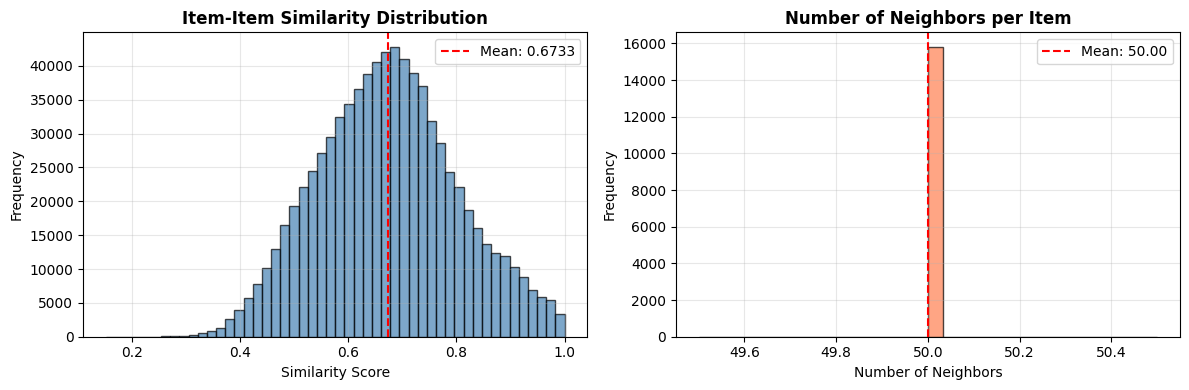

Model characteristics plot saved as 'model_characteristics.png'

Note: ItemKNN is a memory-based method without iterative training.
Similarity matrix computed with k=50 neighbors per item.


In [17]:
# Visualize model characteristics
# Note: ItemKNN is a memory-based method without iterative training loss
# Instead, we visualize the similarity matrix characteristics

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot similarity distribution
similarities = model.item_similarity[model.item_similarity > 0]
axes[0].hist(similarities, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Item-Item Similarity Distribution', fontweight='bold')
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(similarities), color='red', linestyle='--', 
                label=f'Mean: {np.mean(similarities):.4f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot number of neighbors per item
neighbors_per_item = (model.item_similarity > 0).sum(axis=1)
axes[1].hist(neighbors_per_item, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Number of Neighbors per Item', fontweight='bold')
axes[1].set_xlabel('Number of Neighbors')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(neighbors_per_item), color='red', linestyle='--', 
                label=f'Mean: {np.mean(neighbors_per_item):.2f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model characteristics plot saved as 'model_characteristics.png'")
print(f"\nNote: ItemKNN is a memory-based method without iterative training.")
print(f"Similarity matrix computed with k={model.k} neighbors per item.")


## 4. Evaluation


In [18]:
def compute_metrics(y_true, y_pred, k=10):
    """
    Compute evaluation metrics.
    
    Args:
        y_true: Set of true positive items
        y_pred: List of predicted items (top-k)
        k: Cutoff for metrics
        
    Returns:
        Dictionary of metrics
    """
    y_pred_k = set(y_pred[:k])
    y_true_set = set(y_true)
    
    # Intersection of predicted and true items
    hits = len(y_pred_k & y_true_set)
    
    # Recall@k
    recall = hits / len(y_true_set) if len(y_true_set) > 0 else 0.0
    
    # Precision@k
    precision = hits / k if k > 0 else 0.0
    
    # NDCG@k
    ndcg = 0.0
    if hits > 0:
        dcg = 0.0
        for i, item in enumerate(y_pred[:k]):
            if item in y_true_set:
                dcg += 1.0 / np.log2(i + 2)  # i+2 because log2(1) = 0
        
        # Ideal DCG
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(y_true_set), k)))
        ndcg = dcg / idcg if idcg > 0 else 0.0
    
    return {
        'recall': recall,
        'precision': precision,
        'ndcg': ndcg,
        'hits': hits
    }

print("Evaluation functions defined!")


Evaluation functions defined!


In [19]:
def evaluate_model(model, test_matrix, train_matrix, user_to_idx, k_list=[10, 50], sample_users=None):
    """
    Evaluate the model on test set.
    
    Args:
        model: Trained recommendation model
        test_matrix: Test interaction matrix
        train_matrix: Train interaction matrix
        user_to_idx: User to index mapping
        k_list: List of k values for metrics
        sample_users: Number of users to sample (None for all)
    
    Returns:
        Dictionary of results
    """
    # Get test users (users with interactions in test set)
    test_user_indices = np.where(test_matrix.sum(axis=1) > 0)[0]
    
    if sample_users and len(test_user_indices) > sample_users:
        test_user_indices = np.random.choice(test_user_indices, sample_users, replace=False)
    
    print(f"Evaluating on {len(test_user_indices)} users...")
    
    results = {f'metric_{k}': {'recall': [], 'precision': [], 'ndcg': []} for k in k_list}
    
    for user_idx in tqdm(test_user_indices, desc="Evaluating"):
        # Get true positive items from test set
        true_items = np.where(test_matrix[user_idx] > 0)[0].tolist()
        
        if len(true_items) == 0:
            continue
        
        # Get recommendations
        max_k = max(k_list)
        recommendations = model.recommend(user_idx, n_recommendations=max_k, exclude_interacted=True)
        
        # Compute metrics for each k
        for k in k_list:
            metrics = compute_metrics(true_items, recommendations, k=k)
            results[f'metric_{k}']['recall'].append(metrics['recall'])
            results[f'metric_{k}']['precision'].append(metrics['precision'])
            results[f'metric_{k}']['ndcg'].append(metrics['ndcg'])
    
    # Compute average metrics
    summary = {}
    for k in k_list:
        summary[f'recall@{k}'] = np.mean(results[f'metric_{k}']['recall'])
        summary[f'precision@{k}'] = np.mean(results[f'metric_{k}']['precision'])
        summary[f'ndcg@{k}'] = np.mean(results[f'metric_{k}']['ndcg'])
    
    return summary, results

print("Evaluation function defined!")


Evaluation function defined!


In [20]:
# Generate detailed per-user evaluation CSV
def generate_user_evaluation_csv(model, test_matrix, train_matrix, user_to_idx, idx_to_user, idx_to_item, k_list=[10, 50], output_file='results/user_evaluation_details.csv'):
    """
    Generate a CSV file with per-user evaluation results.
    
    Args:
        model: Trained recommendation model
        test_matrix: Test interaction matrix
        train_matrix: Train interaction matrix
        user_to_idx: User to index mapping
        idx_to_user: Index to user mapping
        idx_to_item: Index to item mapping
        k_list: List of k values for metrics
        output_file: Output CSV file path
    
    Returns:
        DataFrame with evaluation results
    """
    # Get test users (users with interactions in test set)
    test_user_indices = np.where(test_matrix.sum(axis=1) > 0)[0]
    
    print(f"Generating evaluation CSV for {len(test_user_indices)} users...")
    
    results = []
    
    for user_idx in tqdm(test_user_indices, desc="Processing users"):
        # Get user ID
        user_id = idx_to_user[user_idx]
        
        # Get true positive items from test set (ground truth)
        true_item_indices = np.where(test_matrix[user_idx] > 0)[0].tolist()
        true_items = [idx_to_item[idx] for idx in true_item_indices]
        
        if len(true_items) == 0:
            continue
        
        # Get recommendations
        max_k = max(k_list)
        recommended_item_indices = model.recommend(user_idx, n_recommendations=max_k, exclude_interacted=True)
        recommended_items = [idx_to_item[idx] for idx in recommended_item_indices]
        
        # Compute metrics for each k
        metrics_dict = {'userID': user_id}
        
        # Add recommended items and ground truth items
        metrics_dict['recommended_items'] = ','.join(recommended_items)  # Join as comma-separated string
        metrics_dict['groundtruth_items'] = ','.join(true_items)  # Join as comma-separated string
        
        # Compute and add metrics for each k
        for k in k_list:
            metrics = compute_metrics(true_item_indices, recommended_item_indices, k=k)
            metrics_dict[f'recall@{k}'] = metrics['recall']
            metrics_dict[f'precision@{k}'] = metrics['precision']
            metrics_dict[f'ndcg@{k}'] = metrics['ndcg']
        
        results.append(metrics_dict)
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    
    # Reorder columns: userID, recommended_items, groundtruth_items, then metrics
    metric_columns = []
    for k in k_list:
        metric_columns.extend([f'recall@{k}', f'precision@{k}', f'ndcg@{k}'])
    
    column_order = ['userID', 'recommended_items', 'groundtruth_items'] + metric_columns
    df_results = df_results[column_order]
    
    # Save to CSV
    df_results.to_csv(output_file, index=False)
    print(f"\nEvaluation CSV saved to '{output_file}'")
    print(f"Total users evaluated: {len(df_results)}")
    print(f"\nColumn names: {', '.join(df_results.columns)}")
    print(f"\nSample of first 3 rows:")
    print(df_results.head(3).to_string())
    
    return df_results

In [21]:
# Example: Get recommendations for a specific user
def get_recommendations_for_user(user_id, model, user_to_idx, idx_to_item, n=10):
    """Get recommendations for a given user ID."""
    if user_id not in user_to_idx:
        return None
    
    user_idx = user_to_idx[user_id]
    recommended_item_indices = model.recommend(user_idx, n_recommendations=n)
    recommended_items = [idx_to_item[idx] for idx in recommended_item_indices]
    
    return recommended_items

# Test with a sample user
sample_user_id = df_test['user_id'].iloc[0]
recommendations = get_recommendations_for_user(
    sample_user_id, 
    model, 
    user_to_idx, 
    idx_to_item, 
    n=10
)

print(f"Sample recommendations for user: {sample_user_id}")
print(f"Recommended items: {recommendations}")


Sample recommendations for user: AF6MAIRKD2RLXDTLBSHJUBBI3YBQ
Recommended items: ['B07M5LY865', 'B07WFL2Y5F', 'B01GQTS3AM', 'B015DLYPJM', 'B07KX7XX1L', 'B07PM731XL', 'B01LP7XM2O', 'B017HP4PYM', 'B084FVVHGZ', 'B08B5LWL74']


In [22]:
# Evaluate on validation set (using test set as validation)
# Sample users for faster evaluation (remove sample_users parameter to evaluate on all)
print("Evaluating model on validation set...")
summary, detailed_results = evaluate_model(
    model, 
    test_matrix, 
    train_matrix, 
    user_to_idx, 
    k_list=[10, 50],
    sample_users=1000  # Sample 1000 users for evaluation
)

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
for metric, value in summary.items():
    print(f"{metric:20s}: {value:.4f}")
print("="*50)


Evaluating model on validation set...
Evaluating on 1000 users...


Evaluating: 100%|██████████| 1000/1000 [14:35<00:00,  1.14it/s]


EVALUATION RESULTS
recall@10           : 0.0080
precision@10        : 0.0009
ndcg@10             : 0.0031
recall@50           : 0.0343
precision@50        : 0.0010
ndcg@50             : 0.0095


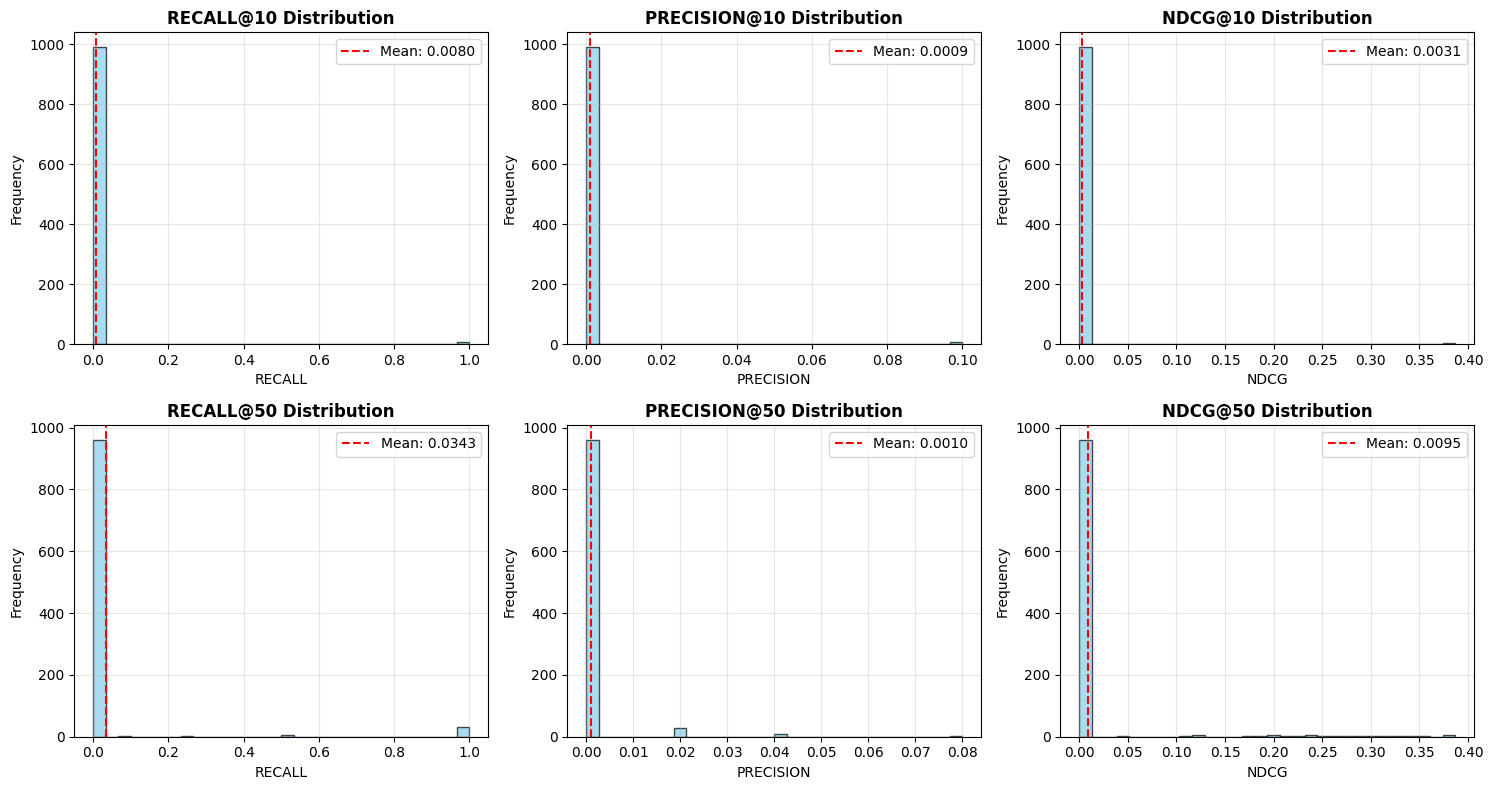

Metrics distribution plot saved as 'metrics_distribution.png'


In [23]:
# Distribution plots for metrics
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for row, k in enumerate([10, 50]):
    for col, metric in enumerate(['recall', 'precision', 'ndcg']):
        data = detailed_results[f'metric_{k}'][metric]
        axes[row, col].hist(data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[row, col].set_title(f'{metric.upper()}@{k} Distribution', fontweight='bold')
        axes[row, col].set_xlabel(metric.upper())
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].axvline(np.mean(data), color='red', linestyle='--', 
                              label=f'Mean: {np.mean(data):.4f}')
        axes[row, col].legend()
        axes[row, col].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Metrics distribution plot saved as 'metrics_distribution.png'")


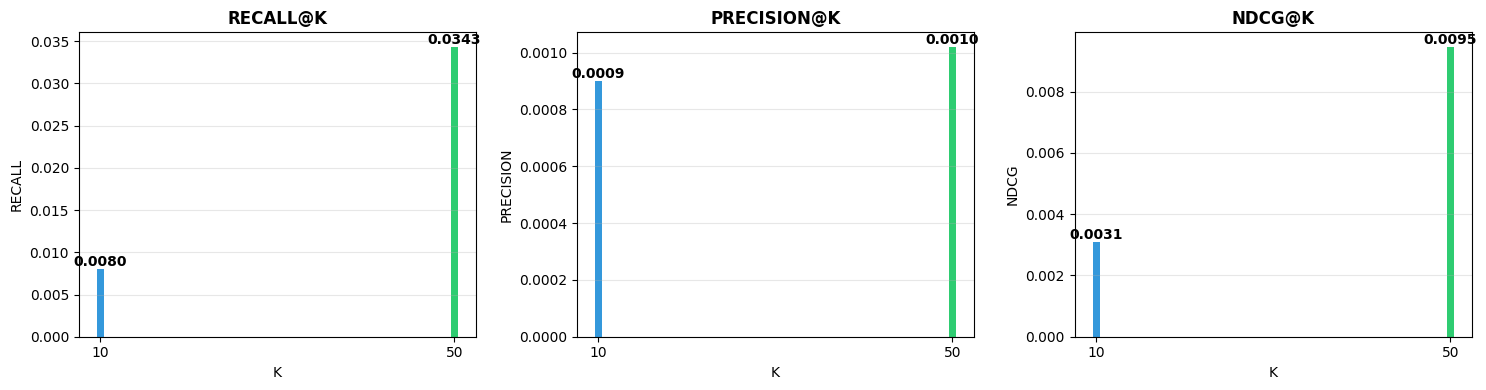

Metrics plot saved as 'metrics_plot.png'


In [24]:
# Plot metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

k_values = [10, 50]
metrics_to_plot = ['recall', 'precision', 'ndcg']

for idx, metric in enumerate(metrics_to_plot):
    values = [summary[f'{metric}@{k}'] for k in k_values]
    axes[idx].bar(k_values, values, color=['#3498db', '#2ecc71'])
    axes[idx].set_title(f'{metric.upper()}@K', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('K')
    axes[idx].set_ylabel(metric.upper())
    axes[idx].set_xticks(k_values)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(values):
        axes[idx].text(k_values[i], v, f'{v:.4f}', 
                      ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Metrics plot saved as 'metrics_plot.png'")


In [25]:
# Generate the detailed evaluation CSV
user_eval_df = generate_user_evaluation_csv(
    model, 
    test_matrix, 
    train_matrix, 
    user_to_idx, 
    idx_to_user, 
    idx_to_item, 
    k_list=[10, 50],
    output_file='user_evaluation_details.csv'
)


Generating evaluation CSV for 2531 users...


Processing users: 100%|██████████| 2531/2531 [36:41<00:00,  1.15it/s]


Evaluation CSV saved to 'user_evaluation_details.csv'
Total users evaluated: 2531

Column names: userID, recommended_items, groundtruth_items, recall@10, precision@10, ndcg@10, recall@50, precision@50, ndcg@50

Sample of first 3 rows:
                         userID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      recommended_items      groundtruth_items  recall@10  precision@10  ndcg@10  recall@50  precision@50  ndcg@50
0  AE23RP4B52KVZCFCCWLARIXJQSDA  B0003TOR7U,B0CH8V66LC,B015DTI1OY,B015DNVQRE,B015DN2KQ0,B0

## 5. Save Results


In [26]:
import pickle
import os

# Create results directory
os.makedirs('results', exist_ok=True)

# Save model
with open('results/itemknn_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved to 'results/itemknn_model.pkl'")

# Save mappings
with open('results/mappings.pkl', 'wb') as f:
    pickle.dump({
        'user_to_idx': user_to_idx,
        'idx_to_user': idx_to_user,
        'item_to_idx': item_to_idx,
        'idx_to_item': idx_to_item
    }, f)
print("Mappings saved to 'results/mappings.pkl'")

# Save evaluation results
results_dict = {
    'summary': summary,
    'detailed_results': {
        k: {
            metric: {
                'mean': np.mean(vals),
                'std': np.std(vals),
                'min': np.min(vals),
                'max': np.max(vals)
            }
            for metric, vals in detailed_results[k].items()
        }
        for k in detailed_results.keys()
    },
    'model_config': {
        'k': model.k,
        'similarity': model.similarity
    },
    'dataset_stats': {
        'n_users': len(user_to_idx),
        'n_items': len(item_to_idx),
        'train_interactions': len(df_train),
        'test_interactions': len(df_test)
    }
}

with open('results/evaluation_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)
print("Evaluation results saved to 'results/evaluation_results.pkl'")

# Save summary as CSV
summary_df = pd.DataFrame([summary])
summary_df.to_csv('results/metrics_summary.csv', index=False)
print("Metrics summary saved to 'results/metrics_summary.csv'")

print("\nAll results saved successfully!")


Model saved to 'results/itemknn_model.pkl'
Mappings saved to 'results/mappings.pkl'
Evaluation results saved to 'results/evaluation_results.pkl'
Metrics summary saved to 'results/metrics_summary.csv'

All results saved successfully!


## 6. Summary


In [27]:
print("="*70)
print("RECOMMENDATION SYSTEM SUMMARY")
print("="*70)

print("\n📊 DATASET STATISTICS:")
print(f"  • Total Users: {len(user_to_idx):,}")
print(f"  • Total Items: {len(item_to_idx):,}")
print(f"  • Train Interactions: {len(df_train):,}")
print(f"  • Test Interactions: {len(df_test):,}")
print(f"  • Train Matrix Density: {(train_matrix > 0).sum() / train_matrix.size * 100:.4f}%")

print("\n🤖 MODEL CONFIGURATION:")
print(f"  • Method: ItemKNN (Item-based Collaborative Filtering)")
print(f"  • Number of Neighbors (k): {model.k}")
print(f"  • Similarity Metric: {model.similarity}")

print("\n📈 EVALUATION METRICS:")
print(f"  • Recall@10: {summary['recall@10']:.4f}")
print(f"  • Recall@50: {summary['recall@50']:.4f}")
print(f"  • Precision@10: {summary['precision@10']:.4f}")
print(f"  • Precision@50: {summary['precision@50']:.4f}")
print(f"  • NDCG@10: {summary['ndcg@10']:.4f}")
print(f"  • NDCG@50: {summary['ndcg@50']:.4f}")

print("\n💾 SAVED FILES:")
print("  • results/itemknn_model.pkl - Trained model")
print("  • results/mappings.pkl - User and item mappings")
print("  • results/evaluation_results.pkl - Detailed evaluation results")
print("  • results/metrics_summary.csv - Metrics summary")
print("  • metrics_plot.png - Metrics visualization")
print("  • metrics_distribution.png - Metrics distribution")

print("\n✅ BASELINE RECOMMENDATION SYSTEM COMPLETE!")
print("="*70)


RECOMMENDATION SYSTEM SUMMARY

📊 DATASET STATISTICS:
  • Total Users: 11,180
  • Total Items: 15,810
  • Train Interactions: 26,008
  • Test Interactions: 6,502
  • Train Matrix Density: 0.0133%

🤖 MODEL CONFIGURATION:
  • Method: ItemKNN (Item-based Collaborative Filtering)
  • Number of Neighbors (k): 50
  • Similarity Metric: cosine

📈 EVALUATION METRICS:
  • Recall@10: 0.0080
  • Recall@50: 0.0343
  • Precision@10: 0.0009
  • Precision@50: 0.0010
  • NDCG@10: 0.0031
  • NDCG@50: 0.0095

💾 SAVED FILES:
  • results/itemknn_model.pkl - Trained model
  • results/mappings.pkl - User and item mappings
  • results/evaluation_results.pkl - Detailed evaluation results
  • results/metrics_summary.csv - Metrics summary
  • metrics_plot.png - Metrics visualization
  • metrics_distribution.png - Metrics distribution

✅ BASELINE RECOMMENDATION SYSTEM COMPLETE!


### Usage Example

To use the trained model for recommendations:

```python
# Load model and mappings
import pickle

with open('results/itemknn_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('results/mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)

# Get recommendations for a user
user_id = "your_user_id"
recommendations = get_recommendations_for_user(
    user_id, 
    model, 
    mappings['user_to_idx'], 
    mappings['idx_to_item'], 
    n=10
)
```
